# Semantic change in Darwin letters
##Corpus processing of Darwin letters

Barbara McGillivray

This notebook contains the code for pre-processing the corpus of Darwin letters and train the embeddings. As some of the steps can take a long time to run, it is advisable to only run this notebook at the beginning of the project, to generate all the files and models needed for the subsequent script, "2_Semantic_change.ipynb".

##License note on data

We will use the letters from the Darwin Correspondence Project (https://www.darwinproject.ac.uk/). The letters have the following license statement: http://creativecommons.org/licenses/by-nc-nd/3.0/ . Many of the texts of the letters are still in copyright to the descendants of the authors. You cannot publish the derivatives of processing these letters nor the letters themselves. 

##1. Initialisation

I install version 4.0 of gensim, which is needed to train the word2vec models.

In [ ]:
!pip install gensim==4.0

     |████████████████████████████████| 23.9 MB 97 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


I install the language detection module:

In [ ]:
!pip install langdetect

     |████████████████████████████████| 981 kB 8.3 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993241 sha256=dd3b1a1541b1d1faf7874d02e931255a21086e953bf7bcb58dfacf3ce119abf8
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect


Download Spacy's English language model:

In [ ]:
!python -m spacy download en

     |████████████████████████████████| 12.0 MB 8.8 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


Import libraries

In [ ]:
import os 
from bs4 import BeautifulSoup
from google.colab import drive
import csv
import numpy as np
import pandas as pd
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import gensim
from scipy import spatial
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
import spacy
import re
from statistics import mean
from langdetect import detect
# to make our plot outputs appear and be stored within the notebook:
%matplotlib inline 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


I mount the Google drive folder. You should change the path to your Google Drive path:

In [ ]:
drive.mount('/content/drive', force_remount = True)
%ls '/content/drive/MyDrive/2021/Darwin paper/Files/'

Mounted at /content/drive
letters/       letters.zip  Models/  Semantic_change_output/
Letters_text/  __MACOSX/    Plots/


##2. Reading the files

I unzip the file containing all the letters. 
**This only needs to be done once** and you can skip this cell.


In [ ]:
!unzip '/content/drive/MyDrive/2021/Darwin paper/Files/letters.zip' -d '/gdrive/My Drive/2021/Darwin paper/Files/Letters'

I define the name of the folder containing the unzipped files:

In [ ]:
folder = '/content/drive/MyDrive/2021/Darwin paper/Files/letters/' 

I define the list of all files:

In [ ]:
files = os.listdir(folder)

How many files are in the folder?


In [ ]:
len(files)

15586

We only want xml files:

In [ ]:
files = [f for f in files[:] if f.endswith(".xml")]
len(files)

15576

### Extracting the text of the letters

I create the output folder:

In [ ]:
out_folder = '/content/drive/My Drive/2021/Darwin paper/Files/Letters_text/' 

We extract the trascribed text from each letter and save it in an output file.  **You can skip this cell.**

In [ ]:
outfile = open(os.path.join(out_folder, 'transcription.csv'), 'w+')
output_writer = csv.writer(outfile, delimiter = "\t")

# Write header row:
output_writer.writerow(["File", "Year", "Sender", "Receiver", "Transcription"]) 

# I initialise the variable "count" to count the files that I'm reading one by one
count = 0

# I loop over each file in the "files" list
for fname in files:
  
  # The variable "count" is incremented
  count += 1
  print("Reading file number", str(count), fname)

  # the following two lines can be commented out if we want all files
  #if count > 200:
  #  break
    
  # I open each file
  with open(os.path.join(folder, fname), "r") as infile:

    # I read the content of the file in the variable "content"
    content = infile.read()

    # Initialize the fields required (sender, receiver, date_sent, keywords, abstract, letter_text):
    sender = ""
    receiver = ""
    date_sent = "" # the date in which the letter was sent
    year = ""
    letter_text = "" # transcription of the letter  

    # I parse the XML of the file with BeautifulSoup
    soup = BeautifulSoup(content,'xml')

    # extract sender, receiver and date_sent:

    corr_action = soup.find_all("correspAction")
    if corr_action:
      # loop over all notes under "correspAction":
      for s in corr_action:
          
        #extract receiver's name:
        if s.get('type') == "received":
          try:
            receiver = s.persName.get_text()
            #print("receiver:", receiver)
          except:
            print("No receiver")

        # extract senders' name:
        if s.get('type') == "sent":
          try:
            sender = s.persName.get_text()  
            #print("sender:", sender)
          except:
            print("No sender")
            
          # extract date sent:                  
          try:
            date_sent = s.date["when"]
            # the year is the first four characters of the date:
            year = date_sent[:4]
          except:
            print("No exact date")
            try:
              date_sent_not_before = s.date["notBefore"]
              # the year is the first four characters of the date:
              year_not_before = date_sent_not_before[:4]
            except:
              print("\tNo notBefore date")
            try:
              date_sent_not_after = s.date["notAfter"]
              year_not_after = date_sent_not_after[:4]
            except:
              print("\tNo notAfter date")
            if date_sent_not_before and date_sent_not_after:
              year = round(float((int(year_not_before)+int(year_not_after))/2))
            elif date_sent_not_before:
              year = year_not_before
            elif date_sent_not_after:
              year = year_not_after

      # extract the transcription of the letters:
      text = soup.find_all("div")
      # I loop over all children of nodes in "div":
      for s in text:
        # I save the text of the transcription in the variable "letter_text"
        if s.get('type') == "transcription":
          letter_text = s.get_text()  
          # Remove newlines and tabs:
          letter_text = letter_text.replace("\n", " ").replace("\r", " ").replace("\t", " ").replace("  ", " ")
          # Remove leading and trailing spaces:
          letter_text = letter_text.strip()
          # test print statement:
          #print("letter_text:", letter_text)
          
      if letter_text == "":
        # If the transcription is empty, I save the variable "letter_text" with the value "TRANSCRIPTION MISSING"
        letter_text = "TRANSCRIPTION MISSING"
        # test print statement:
        #print("Tag_text:", letter_text)

      # I only select those letters for which we have a year and that were sent by or received by Charles Darwin:
      if year is not "" and (sender == "Darwin, C. R." or receiver == "Darwin, C. R.") and letter_text is not "TRANSCRIPTION MISSING":
        # write to output file
        output_writer.writerow([fname, year, sender, receiver, letter_text])
      else:
        print("missing corr_action")                 
      
outfile.close()

I define a dataframe from the csv file:

In [ ]:
df = pd.read_csv(os.path.join(out_folder, 'transcription.csv'), sep = "\t")

In [ ]:
df.shape

(14858, 11)

Number of letters per year

In [ ]:
df1 = df.groupby(['Year']).count()
df1 = df1['File']
df1

Year
1821      1
1822      9
1823      3
1824      2
1825     11
       ... 
1878    561
1879    616
1880    634
1881    711
1882    220
Name: File, Length: 62, dtype: int64

Visualize number of letters per year with a bar plot:

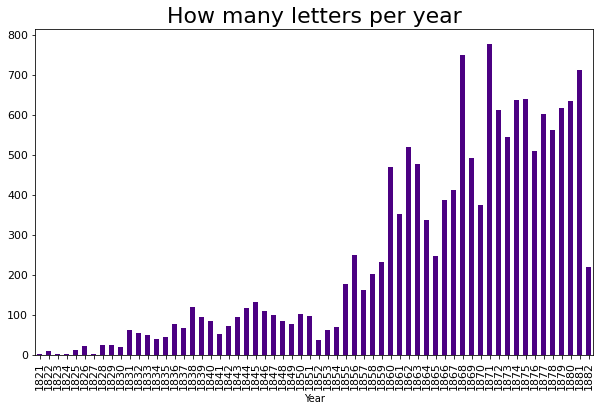

In [ ]:
ax = df1.plot(kind='bar', figsize=(10,6), color="indigo", fontsize=11);
#ax.set_alpha(0.5)
ax.set_title("How many letters per year", fontsize=22)
plt.show()

## 3. Linguistic pre-processing

Add a space before and after every m-dash:

In [ ]:
s = "– – –Museum three — one from"
pat = re.compile(r"(\u2014)")
s = pat.sub(" \\1 ", s)
pat1 = re.compile(r"(\u2013)")
s = pat1.sub(" \\1 ", s)
s = s.replace("  ", " ")
s

' –  –  – Museum three — one from'

In [ ]:
s = "– – –Museum three — one from"
pat = re.compile(r"(\u2014)")
pat1 = re.compile(r"(\u2013)")
s = pat.sub(" \\1 ", pat1.sub(" \\1 ", s)).replace("  ", " ")
s

' –  –  – Museum three — one from'

In [ ]:
pat = re.compile(r"(\u2014)")
pat1 = re.compile(r"(\u2013)")
df['Transcription'] = [pat.sub(" \\1 ", pat1.sub(" \\1 ", df['Transcription'].iloc[i])).replace("  ", " ") for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,Charles Darwin My health keeps much as it was;...
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.",I am very much obliged for your interesting le...
2,DCP-LETT-5961.xml,1868,"Darwin, C. R.","Bush, John",Mr Buckland has told me that you would excuse ...
3,DCP-LETT-2753F.xml,1860,"Darwin, C. R.",Bookseller,"Please procure send me by Post, Mr Pat. Matthe..."
4,DCP-LETT-8607A.xml,1872,"Darwin, C. R.","Murray, John (b)",I have by this same post sent off the few trif...
...,...,...,...,...,...
14910,DCP-LETT-10624.xml,1876,"Darwin, C. R.","Marshall, W. C.",Mr. L. will meet you here on Tuesday. — You ha...
14911,DCP-LETT-10410.xml,1876,"Darwin, C. R.",Unidentified,I have the pleasure to send some autographs as...
14912,DCP-LETT-10604.xml,1876,"Darwin, C. R.","Darwin, Francis","I send by this post Chapt IX, but I earnestly ..."
14913,DCP-LETT-12856.xml,1880,"Pfeffer, W. F. P.","Darwin, C. R.",Although I have so far been able merely to lea...


In [ ]:
df[df['File'] == "DCP-LETT-686.xml"]

,File,Year,Sender,Receiver,Transcription
4883,DCP-LETT-686.xml,1843,"Waterhouse, G. R.","Darwin, C. R.",– – – Museum three — one from Dr. Richardso...


load the spaCy language model:

In [ ]:
sp = spacy.load("en_core_web_sm")

I split the letters into sentences, although this step may not be needed in the end:

In [ ]:
#df['Transcription_sentences'] = [sp(df['Transcription'].iloc[i]) for i in range(df.shape[0])]
df['Transcription_spacy'] = [sp(df['Transcription'].iloc[i]) for i in range(df.shape[0])]
#df['Transcription_sentences'] = [ sentence for sentence in (df['Transcription'].iloc[i]).sents for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,Charles Darwin My health keeps much as it was;...,"(Charles, Darwin, My, health, keeps, much, as,..."
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.",I am very much obliged for your interesting le...,"(I, am, very, much, obliged, for, your, intere..."
2,DCP-LETT-5961.xml,1868,"Darwin, C. R.","Bush, John",Mr Buckland has told me that you would excuse ...,"(Mr, Buckland, has, told, me, that, you, would..."
3,DCP-LETT-2753F.xml,1860,"Darwin, C. R.",Bookseller,"Please procure send me by Post, Mr Pat. Matthe...","(Please, procure, send, me, by, Post, ,, Mr, P..."
4,DCP-LETT-8607A.xml,1872,"Darwin, C. R.","Murray, John (b)",I have by this same post sent off the few trif...,"(I, have, by, this, same, post, sent, off, the..."
...,...,...,...,...,...,...
14910,DCP-LETT-10624.xml,1876,"Darwin, C. R.","Marshall, W. C.",Mr. L. will meet you here on Tuesday. — You ha...,"(Mr., L., , will, meet, you, here, on, Tuesda..."
14911,DCP-LETT-10410.xml,1876,"Darwin, C. R.",Unidentified,I have the pleasure to send some autographs as...,"(I, have, the, pleasure, to, send, some, autog..."
14912,DCP-LETT-10604.xml,1876,"Darwin, C. R.","Darwin, Francis","I send by this post Chapt IX, but I earnestly ...","(I, send, by, this, post, Chapt, IX, ,, but, I..."
14913,DCP-LETT-12856.xml,1880,"Pfeffer, W. F. P.","Darwin, C. R.",Although I have so far been able merely to lea...,"(Although, I, have, so, far, been, able, merel..."


A token simply refers to an individual part of a sentence having some semantic value. Let's see what tokens we have in our document:

In [ ]:
#df['Tokens'] = [[[word.text for word in sent] for sent in df['Transcription_spacy'].iloc[i].sents] for i in range(df.shape[0])]
#df['Tokens'] = [[word.text for word in sent for sent in df['Transcription_spacy'].iloc[i].sents] for i in range(df.shape[0])]
#df['Tokens'] = [[word.text for word in (df['Transcription_sentences'].iloc[i])] for i in range(df.shape[0])]
df['Tokens'] = [[word.text for word in sp(df['Transcription'].iloc[i])] for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,Charles Darwin My health keeps much as it was;...,"(Charles, Darwin, My, health, keeps, much, as,...","[Charles, Darwin, My, health, keeps, much, as,..."
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.",I am very much obliged for your interesting le...,"(I, am, very, much, obliged, for, your, intere...","[I, am, very, much, obliged, for, your, intere..."
2,DCP-LETT-5961.xml,1868,"Darwin, C. R.","Bush, John",Mr Buckland has told me that you would excuse ...,"(Mr, Buckland, has, told, me, that, you, would...","[Mr, Buckland, has, told, me, that, you, would..."
3,DCP-LETT-2753F.xml,1860,"Darwin, C. R.",Bookseller,"Please procure send me by Post, Mr Pat. Matthe...","(Please, procure, send, me, by, Post, ,, Mr, P...","[Please, procure, send, me, by, Post, ,, Mr, P..."
4,DCP-LETT-8607A.xml,1872,"Darwin, C. R.","Murray, John (b)",I have by this same post sent off the few trif...,"(I, have, by, this, same, post, sent, off, the...","[I, have, by, this, same, post, sent, off, the..."
...,...,...,...,...,...,...,...
14910,DCP-LETT-10624.xml,1876,"Darwin, C. R.","Marshall, W. C.",Mr. L. will meet you here on Tuesday. — You ha...,"(Mr., L., , will, meet, you, here, on, Tuesda...","[Mr., L., , will, meet, you, here, on, Tuesda..."
14911,DCP-LETT-10410.xml,1876,"Darwin, C. R.",Unidentified,I have the pleasure to send some autographs as...,"(I, have, the, pleasure, to, send, some, autog...","[I, have, the, pleasure, to, send, some, autog..."
14912,DCP-LETT-10604.xml,1876,"Darwin, C. R.","Darwin, Francis","I send by this post Chapt IX, but I earnestly ...","(I, send, by, this, post, Chapt, IX, ,, but, I...","[I, send, by, this, post, Chapt, IX, ,, but, I..."
14913,DCP-LETT-12856.xml,1880,"Pfeffer, W. F. P.","Darwin, C. R.",Although I have so far been able merely to lea...,"(Although, I, have, so, far, been, able, merel...","[Although, I, have, so, far, been, able, merel..."


In [ ]:
df[df['File'] == "DCP-LETT-686.xml"]

,File,Year,Sender,Receiver,Transcription,Transcription_sentences,Tokens
4883,DCP-LETT-686.xml,1843,"Waterhouse, G. R.","Darwin, C. R.","– – – Museum three — one from Dr. Richardson who is well known there having worked much in the collection; one from Mr Yarrell one from Mr. Bowerbank — I will make it a point to borrow Whewell’s book from Owen to read it the moment he returns — As regards Classification of animals some conclusions I have come to are as follows — That species of animals belonging to the same genus may have an affinity to each other; genera of the same family may have a mutual affinity; relationship of affinity may likewise exist between orders of the same class, but the degree of affinity is different in the different cases — The affinity between species of the same genus may be called an affinity of the first degree; that of genera to genera, of the same family, of the second, or more remote, degree; and, that of families of the third degree so on — Then species of one family have affinity with species of other families of the same order an affinity of the third degree only, and species of different orders of the fourth degree only — That some such feeling as this is impressed upon Naturalists may be inferred from the pains that is taken to place prominently the points of resemblance between animals of different groups of high value — as in the case of the affinity of the ornithrhynchus, or the Echidna, to the Reptiles — the differences here I do not find are dwelt upon with the same ‘gout’ as the points of resemblance — The affinity of the Ornithorhynchus to the Echidna in very much closer than that of either of these animals to the Classes Reptilia, or Aves, — of a different nature as I will undertake to show — That other, and closer links between the Classes may hereafter be found would be stupid to deny, but as a matter of feeling — reasoning from analogies — I do not expect it. There is much to be said on this subject which I will trouble you with hereafter — I have been hard at work at brains for some time past immensely interested with my studies because in some respects I find the result so very different from what I expected. The Whales for instance are placed by Cuvier many Naturalists at the end of the Class Mammalia, yet they have a most highly organized brain — I have puzzled myself much about this matter, for although from all I can learn of the Whales they appear to enjoy a considerable stock of intelligence it does not at all come up to what would be inferred from the consideration of the brain alone — and, it has occurred to me that as the brain is a thing to be educated from without it does not follow that what would be termed a highly organized brain is necessarily followed by corresponding intelligence in the animal — The whales have many of them no olfactory nerves in the others they are in a most rudimentary condition — Their organ of vision does not appear to be particularly good — Of legs they have none their hands most unfitted for touch — and yet this animal has to suckle its young c — he ought to have a good brain to recompense him for the imperfections of the educatory media — Among the Carnivora, the brain of the seal is perhaps one of the highest this poor brute is likewise in a bad school — I mention this as having connexion with “The physiological importance to life of different structures” — I may add that in animals of the same group (in the Quadrumana for instance) there is immense difference in the structure of the brain — species of many groups have a much higher brain than the lowest Quadrumana but none have so good a brain as the highest of that order — as a general rule each group begins as it were lower than its predecessor (beginning at the bottom) terminates higher — each at the same time seems to perfect something — in the organs of respiration, circulation locomotion the bird is higher than Man — Having had my bit of chat I will go to bed — so good night | Always si

### Lemmatisation

In [ ]:
df['Lemmas'] = [[word.lemma_ for word in sp(df['Transcription'].iloc[i])] for i in range(df.shape[0])]
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,Charles Darwin My health keeps much as it was;...,"(Charles, Darwin, My, health, keeps, much, as,...","[Charles, Darwin, My, health, keeps, much, as,...","[Charles, Darwin, -PRON-, health, keep, much, ..."
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.",I am very much obliged for your interesting le...,"(I, am, very, much, obliged, for, your, intere...","[I, am, very, much, obliged, for, your, intere...","[-PRON-, be, very, much, oblige, for, -PRON-, ..."
2,DCP-LETT-5961.xml,1868,"Darwin, C. R.","Bush, John",Mr Buckland has told me that you would excuse ...,"(Mr, Buckland, has, told, me, that, you, would...","[Mr, Buckland, has, told, me, that, you, would...","[Mr, Buckland, have, tell, -PRON-, that, -PRON..."
3,DCP-LETT-2753F.xml,1860,"Darwin, C. R.",Bookseller,"Please procure send me by Post, Mr Pat. Matthe...","(Please, procure, send, me, by, Post, ,, Mr, P...","[Please, procure, send, me, by, Post, ,, Mr, P...","[please, procure, send, -PRON-, by, Post, ,, M..."
4,DCP-LETT-8607A.xml,1872,"Darwin, C. R.","Murray, John (b)",I have by this same post sent off the few trif...,"(I, have, by, this, same, post, sent, off, the...","[I, have, by, this, same, post, sent, off, the...","[-PRON-, have, by, this, same, post, send, off..."
...,...,...,...,...,...,...,...,...
14910,DCP-LETT-10624.xml,1876,"Darwin, C. R.","Marshall, W. C.",Mr. L. will meet you here on Tuesday. — You ha...,"(Mr., L., , will, meet, you, here, on, Tuesda...","[Mr., L., , will, meet, you, here, on, Tuesda...","[Mr., L., , will, meet, -PRON-, here, on, Tu..."
14911,DCP-LETT-10410.xml,1876,"Darwin, C. R.",Unidentified,I have the pleasure to send some autographs as...,"(I, have, the, pleasure, to, send, some, autog...","[I, have, the, pleasure, to, send, some, autog...","[-PRON-, have, the, pleasure, to, send, some, ..."
14912,DCP-LETT-10604.xml,1876,"Darwin, C. R.","Darwin, Francis","I send by this post Chapt IX, but I earnestly ...","(I, send, by, this, post, Chapt, IX, ,, but, I...","[I, send, by, this, post, Chapt, IX, ,, but, I...","[-PRON-, send, by, this, post, Chapt, IX, ,, b..."
14913,DCP-LETT-12856.xml,1880,"Pfeffer, W. F. P.","Darwin, C. R.",Although I have so far been able merely to lea...,"(Although, I, have, so, far, been, able, merel...","[Although, I, have, so, far, been, able, merel...","[although, -PRON-, have, so, far, be, able, me..."


#### Stopwords exclusion and further filtering
I exclude non-alphabetical characters:

In [ ]:
df["Lemmas_clean"] = ''
for i in range(df.shape[0]):
  df['Lemmas_clean'].iloc[i] = [t for t in df['Lemmas'].iloc[i] if t not in '''!()-[]{};:\'"\,<>./?@#$%^&*_~\|–—\“’`''']# and t.isalpha() ]
df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,Charles Darwin My health keeps much as it was;...,"(Charles, Darwin, My, health, keeps, much, as,...","[Charles, Darwin, My, health, keeps, much, as,...","[Charles, Darwin, -PRON-, health, keep, much, ...","[Charles, Darwin, -PRON-, health, keep, much, ..."
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.",I am very much obliged for your interesting le...,"(I, am, very, much, obliged, for, your, intere...","[I, am, very, much, obliged, for, your, intere...","[-PRON-, be, very, much, oblige, for, -PRON-, ...","[-PRON-, be, very, much, oblige, for, -PRON-, ..."
2,DCP-LETT-5961.xml,1868,"Darwin, C. R.","Bush, John",Mr Buckland has told me that you would excuse ...,"(Mr, Buckland, has, told, me, that, you, would...","[Mr, Buckland, has, told, me, that, you, would...","[Mr, Buckland, have, tell, -PRON-, that, -PRON...","[Mr, Buckland, have, tell, -PRON-, that, -PRON..."
3,DCP-LETT-2753F.xml,1860,"Darwin, C. R.",Bookseller,"Please procure send me by Post, Mr Pat. Matthe...","(Please, procure, send, me, by, Post, ,, Mr, P...","[Please, procure, send, me, by, Post, ,, Mr, P...","[please, procure, send, -PRON-, by, Post, ,, M...","[please, procure, send, -PRON-, by, Post, Mr, ..."
4,DCP-LETT-8607A.xml,1872,"Darwin, C. R.","Murray, John (b)",I have by this same post sent off the few trif...,"(I, have, by, this, same, post, sent, off, the...","[I, have, by, this, same, post, sent, off, the...","[-PRON-, have, by, this, same, post, send, off...","[-PRON-, have, by, this, same, post, send, off..."
...,...,...,...,...,...,...,...,...,...
14910,DCP-LETT-10624.xml,1876,"Darwin, C. R.","Marshall, W. C.",Mr. L. will meet you here on Tuesday. — You ha...,"(Mr., L., , will, meet, you, here, on, Tuesda...","[Mr., L., , will, meet, you, here, on, Tuesda...","[Mr., L., , will, meet, -PRON-, here, on, Tu...","[Mr., L., , will, meet, -PRON-, here, on, Tu..."
14911,DCP-LETT-10410.xml,1876,"Darwin, C. R.",Unidentified,I have the pleasure to send some autographs as...,"(I, have, the, pleasure, to, send, some, autog...","[I, have, the, pleasure, to, send, some, autog...","[-PRON-, have, the, pleasure, to, send, some, ...","[-PRON-, have, the, pleasure, to, send, some, ..."
14912,DCP-LETT-10604.xml,1876,"Darwin, C. R.","Darwin, Francis","I send by this post Chapt IX, but I earnestly ...","(I, send, by, this, post, Chapt, IX, ,, but, I...","[I, send, by, this, post, Chapt, IX, ,, but, I...","[-PRON-, send, by, this, post, Chapt, IX, ,, b...","[-PRON-, send, by, this, post, Chapt, IX, but,..."
14913,DCP-LETT-12856.xml,1880,"Pfeffer, W. F. P.","Darwin, C. R.",Although I have so far been able merely to lea...,"(Although, I, have, so, far, been, able, merel...","[Although, I, have, so, far, been, able, merel...","[although, -PRON-, have, so, far, be, able, me...","[although, -PRON-, have, so, far, be, able, me..."


I exclude stop words, although they will be needed for word embedding training:

In [ ]:
stopWords = set(stopwords.words('english'))
df["Lemmas_nostop"] = ''
for i in range(df.shape[0]):
  df['Lemmas_nostop'].iloc[i] = [t for t in df['Lemmas'].iloc[i] if t not in stopWords]
df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean,Lemmas_nostop
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,Charles Darwin My health keeps much as it was;...,"(Charles, Darwin, My, health, keeps, much, as,...","[Charles, Darwin, My, health, keeps, much, as,...","[Charles, Darwin, -PRON-, health, keep, much, ...","[Charles, Darwin, -PRON-, health, keep, much, ...","[Charles, Darwin, -PRON-, health, keep, much, ..."
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.",I am very much obliged for your interesting le...,"(I, am, very, much, obliged, for, your, intere...","[I, am, very, much, obliged, for, your, intere...","[-PRON-, be, very, much, oblige, for, -PRON-, ...","[-PRON-, be, very, much, oblige, for, -PRON-, ...","[-PRON-, much, oblige, -PRON-, interesting, le..."
2,DCP-LETT-5961.xml,1868,"Darwin, C. R.","Bush, John",Mr Buckland has told me that you would excuse ...,"(Mr, Buckland, has, told, me, that, you, would...","[Mr, Buckland, has, told, me, that, you, would...","[Mr, Buckland, have, tell, -PRON-, that, -PRON...","[Mr, Buckland, have, tell, -PRON-, that, -PRON...","[Mr, Buckland, tell, -PRON-, -PRON-, would, ex..."
3,DCP-LETT-2753F.xml,1860,"Darwin, C. R.",Bookseller,"Please procure send me by Post, Mr Pat. Matthe...","(Please, procure, send, me, by, Post, ,, Mr, P...","[Please, procure, send, me, by, Post, ,, Mr, P...","[please, procure, send, -PRON-, by, Post, ,, M...","[please, procure, send, -PRON-, by, Post, Mr, ...","[please, procure, send, -PRON-, Post, ,, Mr, P..."
4,DCP-LETT-8607A.xml,1872,"Darwin, C. R.","Murray, John (b)",I have by this same post sent off the few trif...,"(I, have, by, this, same, post, sent, off, the...","[I, have, by, this, same, post, sent, off, the...","[-PRON-, have, by, this, same, post, send, off...","[-PRON-, have, by, this, same, post, send, off...","[-PRON-, post, send, trifling, erratum, Mr, Cl..."
...,...,...,...,...,...,...,...,...,...,...
14910,DCP-LETT-10624.xml,1876,"Darwin, C. R.","Marshall, W. C.",Mr. L. will meet you here on Tuesday. — You ha...,"(Mr., L., , will, meet, you, here, on, Tuesda...","[Mr., L., , will, meet, you, here, on, Tuesda...","[Mr., L., , will, meet, -PRON-, here, on, Tu...","[Mr., L., , will, meet, -PRON-, here, on, Tu...","[Mr., L., , meet, -PRON-, Tuesday, ., —, -PR..."
14911,DCP-LETT-10410.xml,1876,"Darwin, C. R.",Unidentified,I have the pleasure to send some autographs as...,"(I, have, the, pleasure, to, send, some, autog...","[I, have, the, pleasure, to, send, some, autog...","[-PRON-, have, the, pleasure, to, send, some, ...","[-PRON-, have, the, pleasure, to, send, some, ...","[-PRON-, pleasure, send, autograph, -PRON-, de..."
14912,DCP-LETT-10604.xml,1876,"Darwin, C. R.","Darwin, Francis","I send by this post Chapt IX, but I earnestly ...","(I, send, by, this, post, Chapt, IX, ,, but, I...","[I, send, by, this, post, Chapt, IX, ,, but, I...","[-PRON-, send, by, this, post, Chapt, IX, ,, b...","[-PRON-, send, by, this, post, Chapt, IX, but,...","[-PRON-, send, post, Chapt, IX, ,, -PRON-, ear..."
14913,DCP-LETT-12856.xml,1880,"Pfeffer, W. F. P.","Darwin, C. R.",Although I have so far been able merely to lea...,"(Although, I, have, so, far, been, able, merel...","[Although, I, have, so, far, been, able, merel...","[although, -PRON-, have, so, far, be, able, me...","[although, -PRON-, have, so, far, be, able, me...","[although, -PRON-, far, able, merely, leaf, -P..."


I add the language of the letters in an additional column:

In [ ]:
transcriptions = df[['Transcription']].to_numpy().flatten().tolist()
df[['language']] = [detect(x) for x in transcriptions]

In [ ]:
df

,File,Year,Sender,Receiver,Transcription,Transcription_sentences,Tokens,Lemmas,Lemmas_clean,Lemmas_nostop,language
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,Charles Darwin My health keeps much as it was;...,"(Charles, Darwin, My, health, keeps, much, as,...","[Charles, Darwin, My, health, keeps, much, as,...","[Charles, Darwin, -PRON-, health, keep, much, ...","[Charles, Darwin, -PRON-, health, keep, much, ...","[Charles, Darwin, -PRON-, health, keep, much, ...",en
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.",I am very much obliged for your interesting le...,"(I, am, very, much, obliged, for, your, intere...","[I, am, very, much, obliged, for, your, intere...","[-PRON-, be, very, much, oblige, for, -PRON-, ...","[-PRON-, be, very, much, oblige, for, -PRON-, ...","[-PRON-, much, oblige, -PRON-, interesting, le...",en
2,DCP-LETT-5961.xml,1868,"Darwin, C. R.","Bush, John",Mr Buckland has told me that you would excuse ...,"(Mr, Buckland, has, told, me, that, you, would...","[Mr, Buckland, has, told, me, that, you, would...","[Mr, Buckland, have, tell, -PRON-, that, -PRON...","[Mr, Buckland, have, tell, -PRON-, that, -PRON...","[Mr, Buckland, tell, -PRON-, -PRON-, would, ex...",en
3,DCP-LETT-2753F.xml,1860,"Darwin, C. R.",Bookseller,"Please procure send me by Post, Mr Pat. Matthe...","(Please, procure, send, me, by, Post, ,, Mr, P...","[Please, procure, send, me, by, Post, ,, Mr, P...","[please, procure, send, -PRON-, by, Post, ,, M...","[please, procure, send, -PRON-, by, Post, Mr, ...","[please, procure, send, -PRON-, Post, ,, Mr, P...",en
4,DCP-LETT-8607A.xml,1872,"Darwin, C. R.","Murray, John (b)",I have by this same post sent off the few trif...,"(I, have, by, this, same, post, sent, off, the...","[I, have, by, this, same, post, sent, off, the...","[-PRON-, have, by, this, same, post, send, off...","[-PRON-, have, by, this, same, post, send, off...","[-PRON-, post, send, trifling, erratum, Mr, Cl...",en
...,...,...,...,...,...,...,...,...,...,...,...
14910,DCP-LETT-10624.xml,1876,"Darwin, C. R.","Marshall, W. C.",Mr. L. will meet you here on Tuesday. — You ha...,"(Mr., L., , will, meet, you, here, on, Tuesda...","[Mr., L., , will, meet, you, here, on, Tuesda...","[Mr., L., , will, meet, -PRON-, here, on, Tu...","[Mr., L., , will, meet, -PRON-, here, on, Tu...","[Mr., L., , meet, -PRON-, Tuesday, ., —, -PR...",en
14911,DCP-LETT-10410.xml,1876,"Darwin, C. R.",Unidentified,I have the pleasure to send some autographs as...,"(I, have, the, pleasure, to, send, some, autog...","[I, have, the, pleasure, to, send, some, autog...","[-PRON-, have, the, pleasure, to, send, some, ...","[-PRON-, have, the, pleasure, to, send, some, ...","[-PRON-, pleasure, send, autograph, -PRON-, de...",en
14912,DCP-LETT-10604.xml,1876,"Darwin, C. R.","Darwin, Francis","I send by this post Chapt IX, but I earnestly ...","(I, send, by, this, post, Chapt, IX, ,, but, I...","[I, send, by, this, post, Chapt, IX, ,, but, I...","[-PRON-, send, by, this, post, Chapt, IX, ,, b...","[-PRON-, send, by, this, post, Chapt, IX, but,...","[-PRON-, send, post, Chapt, IX, ,, -PRON-, ear...",en
14913,DCP-LETT-12856.xml,1880,"Pfeffer, W. F. P.","Darwin, C. R.",Although I have so far been able merely to lea...,"(Although, I, have, so, far, been, able, merel...","[Although, I, have, so, far, been, able, merel...","[although, -PRON-, have, so, far, be, able, me...","[although, -PRON-, have, so, far, be, able, me...","[although, -PRON-, far, able, merely, leaf, -P...",en


How many letters per language?

In [ ]:
df[['language']].value_counts()

language
en          14858
de             28
fr             12
ca              7
no              2
vi              1
pt              1
nl              1
id              1
hu              1
et              1
es              1
af              1
dtype: int64

In [ ]:
df.shape

(14915, 11)

Only keep letters in English:

In [ ]:
#df = df[~df.language.isin(['de', 'fr'])]
df = df[df.language.isin(['en'])]
df.shape

(14858, 11)

I save the dataframe to a file:

In [ ]:
df.to_csv(os.path.join(out_folder, 'transcription_tokens.csv'), encoding='utf-8', index = False, sep = "\t")

I read the dataframe from file:

In [ ]:
df = pd.read_csv(os.path.join(out_folder, 'transcription_tokens.csv'), sep = "\t")

In [ ]:
df

,File,Year,Sender,Receiver,Transcription,Transcription_spacy,Tokens,Lemmas,Lemmas_clean,Lemmas_nostop,language
0,DCP-LETT-13876.xml,1871,"Darwin, C. R.",Unidentified,Charles Darwin My health keeps much as it was;...,Charles Darwin My health keeps much as it was;...,"['Charles', 'Darwin', 'My', 'health', 'keeps',...","['Charles', 'Darwin', '-PRON-', 'health', 'kee...","['Charles', 'Darwin', '-PRON-', 'health', 'kee...","['Charles', 'Darwin', '-PRON-', 'health', 'kee...",en
1,DCP-LETT-10515F.xml,1876,"Darwin, C. R.","Zincke, F. B.",I am very much obliged for your interesting le...,I am very much obliged for your interesting le...,"['I', 'am', 'very', 'much', 'obliged', 'for', ...","['-PRON-', 'be', 'very', 'much', 'oblige', 'fo...","['-PRON-', 'be', 'very', 'much', 'oblige', 'fo...","['-PRON-', 'much', 'oblige', '-PRON-', 'intere...",en
2,DCP-LETT-5961.xml,1868,"Darwin, C. R.","Bush, John",Mr Buckland has told me that you would excuse ...,Mr Buckland has told me that you would excuse ...,"['Mr', 'Buckland', 'has', 'told', 'me', 'that'...","['Mr', 'Buckland', 'have', 'tell', '-PRON-', '...","['Mr', 'Buckland', 'have', 'tell', '-PRON-', '...","['Mr', 'Buckland', 'tell', '-PRON-', '-PRON-',...",en
3,DCP-LETT-2753F.xml,1860,"Darwin, C. R.",Bookseller,"Please procure send me by Post, Mr Pat. Matthe...","Please procure send me by Post, Mr Pat. Matthe...","['Please', 'procure', 'send', 'me', 'by', 'Pos...","['please', 'procure', 'send', '-PRON-', 'by', ...","['please', 'procure', 'send', '-PRON-', 'by', ...","['please', 'procure', 'send', '-PRON-', 'Post'...",en
4,DCP-LETT-8607A.xml,1872,"Darwin, C. R.","Murray, John (b)",I have by this same post sent off the few trif...,I have by this same post sent off the few trif...,"['I', 'have', 'by', 'this', 'same', 'post', 's...","['-PRON-', 'have', 'by', 'this', 'same', 'post...","['-PRON-', 'have', 'by', 'this', 'same', 'post...","['-PRON-', 'post', 'send', 'trifling', 'erratu...",en
...,...,...,...,...,...,...,...,...,...,...,...
14853,DCP-LETT-10624.xml,1876,"Darwin, C. R.","Marshall, W. C.",Mr. L. will meet you here on Tuesday. — You ha...,Mr. L. will meet you here on Tuesday. — You ha...,"['Mr.', 'L.', '\xa0', 'will', 'meet', 'you', '...","['Mr.', 'L.', ' ', 'will', 'meet', '-PRON-', ...","['Mr.', 'L.', ' ', 'will', 'meet', '-PRON-', ...","['Mr.', 'L.', ' ', 'meet', '-PRON-', 'Tuesday...",en
14854,DCP-LETT-10410.xml,1876,"Darwin, C. R.",Unidentified,I have the pleasure to send some autographs as...,I have the pleasure to send some autographs as...,"['I', 'have', 'the', 'pleasure', 'to', 'send',...","['-PRON-', 'have', 'the', 'pleasure', 'to', 's...","['-PRON-', 'have', 'the', 'pleasure', 'to', 's...","['-PRON-', 'pleasure', 'send', 'autograph', '-...",en
14855,DCP-LETT-10604.xml,1876,"Darwin, C. R.","Darwin, Francis","I send by this post Chapt IX, but I earnestly ...","I send by this post Chapt IX, but I earnestly ...","['I', 'send', 'by', 'this', 'post', 'Chapt', '...","['-PRON-', 'send', 'by', 'this', 'post', 'Chap...","['-PRON-', 'send', 'by', 'this', 'post', 'Chap...","['-PRON-', 'send', 'post', 'Chapt', 'IX', ',',...",en
14856,DCP-LETT-12856.xml,1880,"Pfeffer, W. F. P.","Darwin, C. R.",Although I have so far been able merely to lea...,Although I have so far been able merely to lea...,"['Although', 'I', 'have', 'so', 'far', 'been',...","['although', '-PRON-', 'have', 'so', 'far', 'b...","['although', '-PRON-', 'have', 'so', 'far', 'b...","['although', '-PRON-', 'far', 'able', 'merely'...",en


## 4. Training word embeddings

Function for printing the vocabulary of a model

In [ ]:
def print_vocab(model, top_n = None):
  count = 0
  if top_n is not None:
    for index, word in enumerate(model.wv.index_to_key):
      count+= 1
      if count < top_n:
        print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")
  else:
    for index, word in enumerate(model.wv.index_to_key):
      print(f"word #{index}/{len(model.wv.index_to_key)} is {word}")

In [ ]:
pd.set_option('display.max_colwidth', -1)
(df['Lemmas_clean'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


0        ['Charles', 'Darwin', '-PRON-', 'health', 'keep', 'much', 'as', '-PRON-', 'be', '-PRON-', 'never', 'escape', 'for', 'a', 'whole', 'day', 'without', 'much', 'discomfort', 'of', 'course', 'as', '-PRON-', 'grow', 'old', '-PRON-', 'become', 'much', 'weak']                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

I train Word2Vec embeddings from the letters. **You can skip this cell.**

`min_count`: the minimum frequency threshold allowed for a word to be included

`vector_size`: the number of dimensions in which we wish to represent our word. This is the size of the word embedding; typically between 100 and 1,000.

`window`: The size of the context window determines how many words before and after a given word would be included as context words of the given word.  Typically between 5 and 10.

`sg`: – Training algorithm: 1 for skip-gram; otherwise CBOW.


In [ ]:
start = time.time()
cbow_w5_f1 = gensim.models.Word2Vec(df['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 0)
end = time.time()
print("It has taken", round(end - start), "seconds")

It has taken 41 seconds


In [ ]:
print_vocab(cbow_w5_f1, 10)

word #0/73956 is -PRON-
word #1/73956 is the
word #2/73956 is be
word #3/73956 is of
word #4/73956 is to
word #5/73956 is have
word #6/73956 is in
word #7/73956 is a
word #8/73956 is that


Different parameters. **You can skip this cell.**

In [ ]:
start = time.time()
cbow_w5_f0 = gensim.models.Word2Vec(df['Lemmas_clean'], min_count=0, vector_size=300, window = 5, sg = 0)
end = time.time()
print("cbow_w5_f0 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f1 = gensim.models.Word2Vec(df['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 1)
end = time.time()
print("sg_w5_f1 has taken", round(end - start), "seconds")
start = time.time()
sg_w5_f0 = gensim.models.Word2Vec(df['Lemmas_clean'], min_count=0, vector_size=300, window = 5, sg = 1)
end = time.time()
print("sg_w5_f0 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f1 = gensim.models.Word2Vec(df['Lemmas_clean'], min_count=1, vector_size=300, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f1 has taken", round(end - start), "seconds")
start = time.time()
cbow_w10_f0 = gensim.models.Word2Vec(df['Lemmas_clean'], min_count=0, vector_size=300, window = 10, sg = 0)
end = time.time()
print("cbow_w10_f0 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f1 = gensim.models.Word2Vec(df['Lemmas_clean'], min_count=1, vector_size=300, window = 10, sg = 1)
end = time.time()
print("sg_w10_f1 has taken", round(end - start), "seconds")
start = time.time()
sg_w10_f0 = gensim.models.Word2Vec(df['Lemmas_clean'], min_count=0, vector_size=300, window = 10, sg = 1)
end = time.time()
print("sg_w10_f0 has taken", round(end - start), "seconds")

cbow_w5_f0 has taken 43 seconds
sg_w5_f1 has taken 137 seconds
sg_w5_f0 has taken 133 seconds
cbow_w10_f1 has taken 46 seconds
cbow_w10_f0 has taken 47 seconds
sg_w10_f1 has taken 227 seconds
sg_w10_f0 has taken 233 seconds


Skip-gram is more computationally expensive, especially with larger window sizes.

Let's save the models so we can use them later. **You can skip this cell.**

In [ ]:
models_folder = '/content/drive/My Drive/2021/Darwin paper/Files/Models'
models = [cbow_w5_f1, cbow_w5_f0, sg_w5_f1, sg_w5_f0, cbow_w10_f1, cbow_w10_f0, sg_w10_f1, sg_w10_f0]
models_names = ["cbow_w5_f1", "cbow_w5_f0", "sg_w5_f1", "sg_w5_f0", "cbow_w10_f1", "cbow_w10_f0", "sg_w10_f1", "sg_w10_f0"]
for i in range(len(models)):
  print("Saving model number", i+1)
  models[i].save(os.path.join(models_folder, models_names[i]))

Saving model number 1
Saving model number 2
Saving model number 3
Saving model number 4
Saving model number 5
Saving model number 6
Saving model number 7
Saving model number 8


Load the models:

In [ ]:
models_folder = '/content/drive/My Drive/2021/Darwin paper/Files/Models'
cbow_w5_f1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f1"))
cbow_w5_f0 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w5_f0"))
sg_w5_f1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f1"))
sg_w5_f0 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w5_f0"))
cbow_w10_f1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f1"))
cbow_w10_f0 = gensim.models.Word2Vec.load(os.path.join(models_folder, "cbow_w10_f0"))
sg_w10_f1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f1"))
sg_w10_f0 = gensim.models.Word2Vec.load(os.path.join(models_folder, "sg_w10_f0"))
models = [cbow_w5_f1, cbow_w5_f0, sg_w5_f1, sg_w5_f0, cbow_w10_f1, cbow_w10_f0, sg_w10_f1, sg_w10_f0]
models_names = ["cbow_w5_f1", "cbow_w5_f0", "sg_w5_f1", "sg_w5_f0", "cbow_w10_f1", "cbow_w10_f0", "sg_w10_f1", "sg_w10_f0"]

Print the first ten words of the vocabulary of each model

In [ ]:
for i in range(len(models)):
  print(models_names[i])
  print_vocab(models[i], 10)

cbow_w5_f1
word #0/73233 is -PRON-
word #1/73233 is the
word #2/73233 is be
word #3/73233 is of
word #4/73233 is to
word #5/73233 is have
word #6/73233 is in
word #7/73233 is a
word #8/73233 is that
cbow_w5_f0
word #0/73233 is -PRON-
word #1/73233 is the
word #2/73233 is be
word #3/73233 is of
word #4/73233 is to
word #5/73233 is have
word #6/73233 is in
word #7/73233 is a
word #8/73233 is that
sg_w5_f1
word #0/73233 is -PRON-
word #1/73233 is the
word #2/73233 is be
word #3/73233 is of
word #4/73233 is to
word #5/73233 is have
word #6/73233 is in
word #7/73233 is a
word #8/73233 is that
sg_w5_f0
word #0/73233 is -PRON-
word #1/73233 is the
word #2/73233 is be
word #3/73233 is of
word #4/73233 is to
word #5/73233 is have
word #6/73233 is in
word #7/73233 is a
word #8/73233 is that
cbow_w10_f1
word #0/73233 is -PRON-
word #1/73233 is the
word #2/73233 is be
word #3/73233 is of
word #4/73233 is to
word #5/73233 is have
word #6/73233 is in
word #7/73233 is a
word #8/73233 is that
cbow_w10

Let's look at the most similar words (i.e. neighbours) of *letter*:

In [ ]:
for i in range(len(models)):
  print(models_names[i], models[i].wv.similar_by_word('letter', 10))

cbow_w5_f1 [('note', 0.8678285479545593), ('pamphlet', 0.6200991272926331), ('article', 0.5815362930297852), ('message', 0.573894739151001), ('communication', 0.5719612240791321), ('reply', 0.5667127966880798), ('delay', 0.5487687587738037), ('query', 0.5345604419708252), ('memorandum', 0.5316326022148132), ('conversation', 0.530711829662323)]
cbow_w5_f0 [('note', 0.8598514199256897), ('communication', 0.596707820892334), ('pamphlet', 0.5930449962615967), ('message', 0.5780489444732666), ('Resumé', 0.5745941400527954), ('article', 0.5699095129966736), ('reply', 0.5689553618431091), ('delay', 0.5465525388717651), ('correspondence', 0.5434944033622742), ('writing', 0.5428488254547119)]
sg_w5_f1 [('message', 0.7341537475585938), ('note', 0.7340550422668457), ('epistle', 0.73135906457901), ('Letter', 0.7195678353309631), ('budget', 0.7191872596740723), ('yarn', 0.7100235819816589), ('rigmarole', 0.7010443806648254), ('effusion', 0.699583888053894), ('diary', 0.6945642232894897), ('recieve'

#### Model choice
In order to do a systematic evaluation and choose the best model for our purposes, we would need to test them all against some "gold standard", e.g. a list of known synonyms for this corpus. This is the list suggested by Liz:
superfluous, unnecessary
Display, exhibit
Mimetic, imitative
Disappear, vanish
Alike, identical

In [ ]:
synonyms = dict({"superfluous": "unnecessary", "display": "exhibit", "mimetic" : "imitative", "disappear" : "vanish", "alike" : "identical"})
synonyms

{'alike': 'identical',
 'disappear': 'vanish',
 'display': 'exhibit',
 'mimetic': 'imitative',
 'superfluous': 'unnecessary'}

Check that the synonym pairs are preserved by the models:

In [ ]:
models_synonymity_average = dict()
for i in range(len(models)):
  print("Model", models_names[i])
  average_synonimity = 0
  synonymities = list()
  for s1 in synonyms:
    print("\tSimilarity between", s1, "and", synonyms[s1],  "in", models_names[i], models[i].wv.similarity(s1, synonyms[s1]))
    synonymities.append(models[i].wv.similarity(s1, synonyms[s1]))
  average_synonimity = mean(synonymities)
  print(average_synonimity)
  models_synonymity_average[models_names[i]] = average_synonimity
models_synonymity_average

Model cbow_w5_f1
	Similarity between superfluous and unnecessary in cbow_w5_f1 0.6309135
	Similarity between display and exhibit in cbow_w5_f1 0.7444048
	Similarity between mimetic and imitative in cbow_w5_f1 0.547817
	Similarity between disappear and vanish in cbow_w5_f1 0.6963
	Similarity between alike and identical in cbow_w5_f1 0.62790227
0.6494675
Model cbow_w5_f0
	Similarity between superfluous and unnecessary in cbow_w5_f0 0.63728154
	Similarity between display and exhibit in cbow_w5_f0 0.7189475
	Similarity between mimetic and imitative in cbow_w5_f0 0.53456205
	Similarity between disappear and vanish in cbow_w5_f0 0.6981334
	Similarity between alike and identical in cbow_w5_f0 0.63300073
0.64438504
Model sg_w5_f1
	Similarity between superfluous and unnecessary in sg_w5_f1 0.7909858
	Similarity between display and exhibit in sg_w5_f1 0.6874959
	Similarity between mimetic and imitative in sg_w5_f1 0.6940794
	Similarity between disappear and vanish in sg_w5_f1 0.7727714
	Similari

{'cbow_w10_f0': 0.5591407,
 'cbow_w10_f1': 0.56228185,
 'cbow_w5_f0': 0.64438504,
 'cbow_w5_f1': 0.6494675,
 'sg_w10_f0': 0.6351944,
 'sg_w10_f1': 0.63721013,
 'sg_w5_f0': 0.69254327,
 'sg_w5_f1': 0.71121836}

I choose the model that maximises the average similarity between synonyms:

In [ ]:
model_chosen_name = max(models_synonymity_average, key=models_synonymity_average.get)
for i in range(len(models)):
  if models_names[i] == model_chosen_name:
    models[i].save(os.path.join(models_folder, "Chosen_model"))
model_chosen_name

'sg_w5_f1'

# Semantic change 

Step 1: Define two time periods and split the corpus

In [ ]:
date = 1870
time_period_1 = list(range(min(df['Year']),date+1))
time_period_2 = list(range(date+1,max(df['Year'])+1))

In [ ]:
df1 = df[df['Year'].isin(time_period_1)]
df2 = df[df['Year'].isin(time_period_2)]

Check the start and end dates:

In [ ]:
max(df1['Year'])

1870

In [ ]:
min(df2['Year'])

1871

Check that I haven't lost any line:

In [ ]:
df.shape[0] == df1.shape[0] + df2.shape[0]

True

## Step 2. Train word embeddings for the two time periods


I train two word2vec models, one for each dataframe corresponding to a time period. I choose the parameters that led to the best model (see script 1_Corpus_Processing script). This takes approximately 5 minutes. **You can skip this cell.**

In [ ]:
model1 = gensim.models.Word2Vec(df1['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 1)
model2 = gensim.models.Word2Vec(df2['Lemmas_clean'], min_count=1, vector_size=300, window = 5, sg = 1)

Save the models. **You can skip this cell.**

In [ ]:
models_folder = '/content/drive/My Drive/2021/Darwin paper/Files/Models'
models = [model1, model2]
models_names = ["model1", "model2"]
for i in range(len(models)):
  print("Saving model number", i+1)
  models[i].save(os.path.join(models_folder, models_names[i]))

Saving model number 1
Saving model number 2


I load the models:

In [ ]:
models_folder = '/content/drive/My Drive/2021/Darwin paper/Files/Models'
model1 = gensim.models.Word2Vec.load(os.path.join(models_folder, "model1"))
model2 = gensim.models.Word2Vec.load(os.path.join(models_folder, "model2"))
models = [model1, model2]
models_names = ["model1", "model2"]

What are the vocabularies of these models?

In [ ]:
print_vocab(model1, 10)

word #0/54516 is -PRON-
word #1/54516 is the
word #2/54516 is be
word #3/54516 is of
word #4/54516 is to
word #5/54516 is have
word #6/54516 is in
word #7/54516 is a
word #8/54516 is that


In [ ]:
print_vocab(model2,10)

word #0/42040 is -PRON-
word #1/42040 is the
word #2/42040 is be
word #3/42040 is of
word #4/42040 is to
word #5/42040 is in
word #6/42040 is have
word #7/42040 is a
word #8/42040 is that


In [ ]:
print(str(len(list(model1.wv.index_to_key))))
print(str(len(list(model2.wv.index_to_key))))

54516
42040


The intersection between the vocabularies of the two models:

In [ ]:
vocab1 = set(list(model1.wv.index_to_key))
vocab2 = set(list(model2.wv.index_to_key))
len(vocab1.intersection(vocab2))

23323

## Step 3. Embedding space alignment

I will be using code from https://gist.github.com/zhicongchen/9e23d5c3f1e5b1293b16133485cd17d8, ported from HistWords <https://github.com/williamleif/histwords>.

First, I define a function to find the intersection between the vocabularies of two word2vec models:

In [ ]:
def intersection_align_gensim(m1, m2, words=None):
    """
    Intersect two gensim word2vec models, m1 and m2.
    Only the shared vocabulary between them is kept.
    If 'words' is set (as list or set), then the vocabulary is intersected with this list as well.
    Indices are re-organized from 0..N in order of descending frequency (=sum of counts from both m1 and m2).
    These indices correspond to the new syn0 and syn0norm objects in both gensim models:
        -- so that Row 0 of m1.syn0 will be for the same word as Row 0 of m2.syn0
        -- you can find the index of any word on the .index2word list: model.index2word.index(word) => 2
    The .vocab dictionary is also updated for each model, preserving the count but updating the index.
    """

    # Get the vocab for each model
    vocab_m1 = set(m1.wv.index_to_key)
    vocab_m2 = set(m2.wv.index_to_key)

    # Find the common vocabulary
    common_vocab = vocab_m1 & vocab_m2
    if words: common_vocab &= set(words)

    # If no alignment necessary because vocab is identical...
    if not vocab_m1 - common_vocab and not vocab_m2 - common_vocab:
        return (m1,m2)

    # Otherwise sort by frequency (summed for both)
    common_vocab = list(common_vocab)
    common_vocab.sort(key=lambda w: m1.wv.get_vecattr(w, "count") + m2.wv.get_vecattr(w, "count"), reverse=True)
    # print(len(common_vocab))

    # Then for each model...
    for m in [m1, m2]:
        # Replace old syn0norm array with new one (with common vocab)
        indices = [m.wv.key_to_index[w] for w in common_vocab]
        old_arr = m.wv.vectors
        new_arr = np.array([old_arr[index] for index in indices])
        m.wv.vectors = new_arr

        # Replace old vocab dictionary with new one (with common vocab)
        # and old index2word with new one
        new_key_to_index = {}
        new_index_to_key = []
        for new_index, key in enumerate(common_vocab):
            new_key_to_index[key] = new_index
            new_index_to_key.append(key)
        m.wv.key_to_index = new_key_to_index
        m.wv.index_to_key = new_index_to_key
        
        print(len(m.wv.key_to_index), len(m.wv.vectors))
        
    return (m1,m2)

Then, I define a function for aligning two spaces with [Orthogonal Procrustes](https://simonensemble.github.io/2018-10/orthogonal-procrustes.html):

In [ ]:
def smart_procrustes_align_gensim(base_embed, other_embed, words=None):
    """
    Original script: https://gist.github.com/quadrismegistus/09a93e219a6ffc4f216fb85235535faf
    Procrustes align two gensim word2vec models (to allow for comparison between same word across models).
    Code ported from HistWords <https://github.com/williamleif/histwords> by William Hamilton <wleif@stanford.edu>.
        
    First, intersect the vocabularies (see `intersection_align_gensim` documentation).
    Then do the alignment on the other_embed model.
    Replace the other_embed model's syn0 and syn0norm numpy matrices with the aligned version.
    Return other_embed.
    If `words` is set, intersect the two models' vocabulary with the vocabulary in words (see `intersection_align_gensim` documentation).
    """

    # make sure vocabulary and indices are aligned
    in_base_embed, in_other_embed = intersection_align_gensim(base_embed, other_embed, words=words)

    # get the (normalized) embedding matrices
    base_vecs = in_base_embed.wv.get_normed_vectors()
    other_vecs = in_other_embed.wv.get_normed_vectors()

    # just a matrix dot product with numpy
    m = other_vecs.T.dot(base_vecs) 
    # SVD method from numpy
    u, _, v = np.linalg.svd(m)
    # another matrix operation
    ortho = u.dot(v) 
    # Replace original array with modified one, i.e. multiplying the embedding matrix by "ortho"
    other_embed.wv.vectors = (other_embed.wv.vectors).dot(ortho)    
    
    return other_embed

Now I can apply the function to my models:

In [ ]:
smart_procrustes_align_gensim(model1, model2, words=None)

23323 23323
23323 23323


Now the two models have been aligned and have the same vocabulary:

In [ ]:
len(model1.wv.index_to_key)

23323

In [ ]:
len(model2.wv.index_to_key)

23323

In [ ]:
model1.wv.index_to_key == model2.wv.index_to_key

True

I print the vocabulary:

In [ ]:
model1.wv.index_to_key

['-PRON-',
 'the',
 'be',
 'of',
 'to',
 'have',
 'in',
 'a',
 'that',
 '  ',
 'and',
 'not',
 'for',
 'as',
 'on',
 'with',
 'but',
 'which',
 'very',
 'will',
 'this',
 'do',
 'at',
 'by',
 'from',
 'or',
 'so',
 'if',
 'one',
 'all',
 'think',
 'much',
 'can',
 'some',
 'would',
 'see',
 'any',
 'about',
 'Darwin',
 'an',
 'may',
 'more',
 'send',
 'there',
 'say',
 'no',
 'make',
 'other',
 'when',
 'good',
 'know',
 'what',
 'most',
 'time',
 '’s',
 'give',
 'find',
 'great',
 'work',
 'now',
 'write',
 'letter',
 'shall',
 'well',
 'plant',
 'than',
 'believe',
 'only',
 'go',
 'many',
 'like',
 'take',
 'out',
 'hope',
 'get',
 'must',
 'two',
 'specie',
 'case',
 'thank',
 'such',
 'come',
 'dear',
 'hear',
 'these',
 'could',
 'how',
 'up',
 'day',
 'should',
 'little',
 'Sir',
 'same',
 'seem',
 'year',
 'read',
 'long',
 'who',
 'tell',
 'man',
 'book',
 'here',
 'whether',
 'kind',
 'last',
 'ever',
 'quite',
 'sincerely',
 'also',
 'C.',
 'leave',
 'first',
 'Yours',
 'few

I save the aligned models:

In [ ]:
for i in range(len(models)):
  print(models_names[i])
  models[i].save(os.path.join(models_folder, models_names[i] + "_aligned"))

model1
model2


Let's look at the similarity between two words in the two spaces:

In [ ]:
model1.wv.similarity("letter", "note")

0.77630043

In [ ]:
model2.wv.similarity("letter", "note")

0.8022867

## Step 4: Measure change

Now I can measure the cosine similarity between the embedding of a word in the first time period and the embedding of the same word in the second time period. 

Let's define a function that calculates the semantic change of a word:

In [ ]:
def semantic_change(word):
  sc = 1-spatial.distance.cosine(model1.wv[word], model2.wv[word])
  return sc

Now I calculate the semantic change for all words in the vocabulary, and store this in the dataframe semantic_change; I also add a column for the frequency of the word in the first space and another one for its frequency in the second space:

In [ ]:
semantic_change_df = pd.DataFrame(([w, semantic_change(w), model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in model1.wv.index_to_key), columns = ('Word', 'Semantic_change', "Frequency_t1", "Frequency_t2"))
semantic_change_df

,Word,Semantic_change,Frequency_t1,Frequency_t2
0,-PRON-,0.948145,284506,174605
1,the,0.921888,129459,90613
2,be,0.936277,102383,62432
3,of,0.909728,87876,59302
4,to,0.920290,78925,52600
...,...,...,...,...
23318,Mygale,0.863666,2,1
23319,satin,0.950452,2,1
23320,foraminifera,0.952742,2,1
23321,Dalyell,0.944407,2,1


Visualise the distribution of the semantic change scores with a histogram:

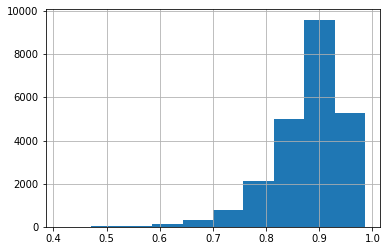

In [ ]:
hist = semantic_change_df['Semantic_change'].hist()

Now I sort by decreasing semantic change score:

In [ ]:
semantic_change_df_sorted = semantic_change_df.sort_values(by='Semantic_change', ascending=False)
semantic_change_df_sorted.head()

,Word,Semantic_change,Frequency_t1,Frequency_t2
8052,Boyd,0.986384,12,7
18328,avec,0.985623,3,2
16705,vom,0.983580,4,2
11502,mit,0.982179,7,4
21515,Familie,0.982051,2,2


I add the total frequency:

In [ ]:
semantic_change_df_sorted["Total_Frequency"] = semantic_change_df_sorted["Frequency_t1"]+semantic_change_df_sorted["Frequency_t2"]
semantic_change_df_sorted

,Word,Semantic_change,Frequency_t1,Frequency_t2,Total_Frequency
8052,Boyd,0.986384,12,7,19
18328,avec,0.985623,3,2,5
16705,vom,0.983580,4,2,6
11502,mit,0.982179,7,4,11
21515,Familie,0.982051,2,2,4
...,...,...,...,...,...
3716,Sara,0.474424,41,26,67
5527,Caspary,0.471753,22,14,36
2640,Utricularia,0.468762,68,43,111
4047,1879,0.467864,36,23,59


I add a column with the category (function word, foreign word, numeral, and proper noun).

List of function words (from https://www.eltconcourse.com/training/initial/lexis/function_words.html)

In [ ]:
function_words = ['after', 'although', 'and', 'as', 'because', 'before', 'both', 'but', 'either', 'for', 'however', 'if','neither','nor','once','or','since','so','than','that','therefore','though','thus','till','unless','until','when','whenever','where','wherever','whether','while','yet	a','all','another','any','both','each','either','every','her','his','its','my','neither','no','other','our','per','some','that','the','their','these','this','those','whatever','whichever','your	about','above','across','after','against','ahead','along','among','amongst','around','as','at','bar','before','behind','below','beneath','beside','besides','between','beyond','but','by','down','during','except','for','from','in','inside','into','less','like	near','of','off','on','onto','opposite','outside','over','past','per','round','save','since','through','till','to','toward','under','underneath','until','up','upon','with','within','without	all','another','any','anybody','anyone','anything','both','each','either','everybody','everyone','everything','few','he','I','it','many','mine','neither','nobody','none','nothing','one','other','several','she','some','somebody','someone','something','that','these','they	this','those','we','what','whatever','which','whichever','who','whoever','whom','whose','you']

Applying the detect package doesn't work on individual words so I use the NLTK's English dictionary instead:

In [ ]:
#semantic_change.df.sorted['Language'] = semantic_change.df.sorted['Word'].apply(detect) 
import nltk
nltk.download('words')
english_vocab = set(w.lower() for w in nltk.corpus.words.words())
len(english_vocab)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


234377

In [ ]:
# create a list of our conditions
conditions = [
    (semantic_change_df_sorted['Word'].isin(function_words)), # function words
    ((semantic_change_df_sorted.Word.str.isdigit()) | (semantic_change_df_sorted['Word'].str.match('^\d*?1st$')) | (semantic_change_df_sorted['Word'].str.match('^\d*?2nd$')) | (semantic_change_df_sorted['Word'].str.match('^\d*?3rd$')) | (semantic_change_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (semantic_change_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(semantic_change_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]

# create a list of the values we want to assign for each condition
values = ['Function word','Numeral', 'Proper noun', 'Foreign word']

# create a new column and use np.select to assign values to it using our lists as arguments
semantic_change_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
semantic_change_df_sorted

,Word,Semantic_change,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
8052,Boyd,0.986384,12,7,19,Proper noun
18328,avec,0.985623,3,2,5,Foreign word
16705,vom,0.983580,4,2,6,Foreign word
11502,mit,0.982179,7,4,11,Foreign word
21515,Familie,0.982051,2,2,4,Proper noun
...,...,...,...,...,...,...
3716,Sara,0.474424,41,26,67,Proper noun
5527,Caspary,0.471753,22,14,36,Proper noun
2640,Utricularia,0.468762,68,43,111,Proper noun
4047,1879,0.467864,36,23,59,Numeral


In [ ]:
semantic_change_df_sorted[semantic_change_df_sorted['Category_automatic'] == 'Function word']

,Word,Semantic_change,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
4024,everybody,0.936484,36,23,59,Function word
29,all,0.934478,10144,5332,15476,Function word
5522,whoever,0.933912,22,14,36,Function word
4166,anybody,0.929446,34,22,56,Function word
8,that,0.928863,32756,22892,55648,Function word
...,...,...,...,...,...,...
939,mine,0.773120,278,170,448,Function word
745,amongst,0.758922,350,222,572,Function word
216,between,0.750352,1337,871,2208,Function word
1058,neither,0.737989,238,151,389,Function word


I save this to a file:

In [ ]:
output_folder = '/content/drive/MyDrive/2021/Darwin paper/Files/Semantic_change_output/'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
semantic_change_df_sorted.to_csv(os.path.join(output_folder, 'semantic_change_all_words.csv'), encoding='utf-8')

The top most changed words:

In [ ]:
semantic_change_df_sorted.head(100)

,Word,Semantic_change,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
8052,Boyd,0.986384,12,7,19,Proper noun
18328,avec,0.985623,3,2,5,Foreign word
16705,vom,0.983580,4,2,6,Foreign word
11502,mit,0.982179,7,4,11,Foreign word
21515,Familie,0.982051,2,2,4,Proper noun
...,...,...,...,...,...,...
21809,Vereins,0.971393,2,1,3,Proper noun
22762,galvanization,0.971372,2,1,3,
22432,veined,0.971318,2,1,3,
20816,dau,0.971283,2,2,4,Foreign word


I plot the terms by their total frequency and semantic change score:

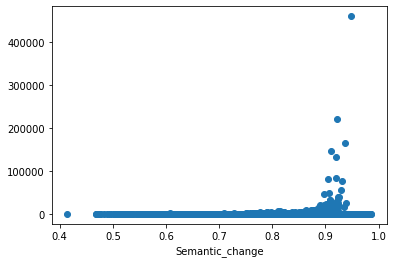

In [ ]:
ax = semantic_change.df.sorted.set_index('Semantic_change')['Total_Frequency'].plot(style='o')

Which words are the outliers? Function words and *Darwin*:

In [ ]:
semantic_change_df_sorted.loc[semantic_change.df.sorted['Total_Frequency'] > 10000].Word.tolist()

['-PRON-',
 'very',
 'be',
 'all',
 'a',
 'that',
 'not',
 'so',
 'which',
 'as',
 'for',
 'the',
 'will',
 'have',
 'but',
 'to',
 'this',
 'can',
 'if',
 'much',
 'send',
 'some',
 'any',
 'do',
 'of',
 'with',
 'on',
 'about',
 '  ',
 'think',
 'in',
 'see',
 'one',
 'may',
 'an',
 'at',
 'more',
 'from',
 'and',
 'or',
 'by',
 'Darwin',
 'would']

I exclude the outliers:

In [ ]:
semantic_change_df_sorted1 = semantic_change_df_sorted.loc[semantic_change_df_sorted['Total_Frequency'] < 10000]
semantic_change_df_sorted1.shape

(23280, 6)

Plot:

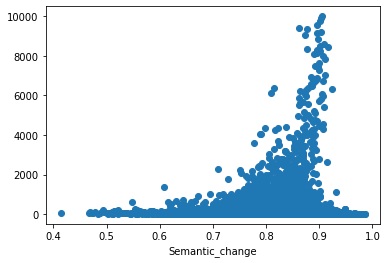

In [ ]:
ax = semantic_change.df.sorted1.set_index('Semantic_change')['Total_Frequency'].plot(style='o')

What is the semantic change of the words we have chosen?

In [ ]:
words_chosen = ['protoplasm', 'curious', 'fertilisation', 'fertilise', 'analogy', 'analogous', 'homology', 'homologous', 'cleistogamic', 'physiology', 'physiological', 'ferment', 'science', 'scientist', 'scientific', 'evolution', 'evolutionary', 'evolve']

In [ ]:
semantic_change_df_sorted[semantic_change_df_sorted['Word'] == "fertilise"]


,Word,Semantic_change,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
942,fertilise,0.818965,276,170,446,Foreign word


In [ ]:
semantic_change_chosen = semantic_change_df_sorted[semantic_change_df_sorted['Word'].isin(words_chosen)]
semantic_change_chosen.to_csv(os.path.join(output_folder, 'semantic_change_chosen_words.csv'), encoding='utf-8')
semantic_change_chosen

,Word,Semantic_change,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
5066,evolve,0.920679,25,16,41,
4845,homologous,0.894817,27,17,44,
418,science,0.890775,672,433,1105,
6454,scientist,0.884423,17,11,28,
1948,analogy,0.874601,104,66,170,
1577,evolution,0.867100,144,90,234,
226,curious,0.864776,1283,840,2123,
1180,analogous,0.853460,211,133,344,
4113,homology,0.842890,35,22,57,
421,scientific,0.839234,656,430,1086,


In [ ]:
min(semantic_change_chosen.Semantic_change)

0.6384909152984619

In [ ]:
min(semantic_change_chosen.Total_Frequency)

28

Now I focus on those words that have a frequency higher than min(semantic_change_chosen.Total_Frequency) and a semantic change score above min(semantic_change_chosen.Semantic_change). How many are there?

In [ ]:
semantic_change_df_sorted_filtered = semantic_change_df_sorted1.loc[(semantic_change_df_sorted1['Total_Frequency'] > min(semantic_change_chosen.Total_Frequency)) & (semantic_change_df_sorted1['Semantic_change'] > min(semantic_change_chosen.Semantic_change))]
semantic_change_df_sorted_filtered.shape

(6135, 6)

Which words are these words?

In [ ]:
semantic_change_df_sorted_filtered

,Word,Semantic_change,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
3624,Servant,0.968065,42,27,69,Proper noun
5439,Truly,0.965719,22,14,36,Proper noun
4998,servt,0.956619,26,16,42,Foreign word
5551,F.L.S.,0.956397,21,14,35,Foreign word
4757,My,0.956320,28,17,45,Proper noun
...,...,...,...,...,...,...
5945,phthisis,0.641621,19,12,31,
6152,Bath,0.641087,18,12,30,Proper noun
5124,Cohn,0.640565,25,16,41,Proper noun
2812,Great,0.640072,62,39,101,Proper noun


Neighbours of *fertilisation* in the two time periods:

In [ ]:
print(model1.wv.similar_by_word("fertilisation", 10))
print(model2.wv.similar_by_word("fertilisation", 10))
semantic_change_df_sorted_filtered[semantic_change_df_sorted_filtered['Word'] == "fertilisation"]

[('fertilization', 0.8758518695831299), ('contrivance', 0.8129968643188477), ('impregnation', 0.8084515333175659), ('Passiflora', 0.8014850616455078), ('agency', 0.7770189046859741), ('orchid', 0.7742666602134705), ('impotence', 0.7644632458686829), ('self', 0.7620887756347656), ('orchis', 0.7603682279586792), ('Catasetum', 0.7582208514213562)]
[('fertilization', 0.9029184579849243), ('carnivorous', 0.7927517294883728), ('Alpine', 0.7897111773490906), ('Self', 0.7889799475669861), ('fertilize', 0.7871734499931335), ('alpine', 0.786170482635498), ('cross-', 0.7830774188041687), ('fertilise', 0.7808493971824646), ('contrivance', 0.7806875109672546), ('Lepidoptera', 0.7777403593063354)]


,Word,Semantic_change,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
944,fertilisation,0.808385,275,170,445,Foreign word


I create a list for these words:

In [ ]:
highfreq_highlychanged_words = semantic_change_df_sorted_filtered.Word.tolist()
highfreq_highlychanged_words

['Servant',
 'Truly',
 'servt',
 'F.L.S.',
 'My',
 'Pres',
 'obedt',
 'que',
 'presentation',
 'troubling',
 'lunch',
 '72',
 'Reade',
 'Esqr',
 'obedient',
 'den',
 'Esqre',
 'respectful',
 'obediently',
 'molecule',
 '81',
 'untidy',
 'consistent',
 'heartfelt',
 'herewith',
 'Edn',
 'offend',
 'Victor',
 'Madam',
 'fundamental',
 'overwork',
 'govern',
 'inevitable',
 'inconvenient',
 'Hon',
 'sympathise',
 'FRS',
 'Friend',
 'behalf',
 'brisk',
 'spiritual',
 'warmly',
 'Geo',
 'Printers',
 'criticise',
 'ungrateful',
 'roof',
 'decent',
 'affecly',
 'window',
 '105',
 'everybody',
 'conveniently',
 'assurance',
 'Traherne',
 'token',
 'Haste',
 'pp',
 'gratified',
 'overwhelmed',
 'deduce',
 'latent',
 'Respectfully',
 'Mess',
 'proportional',
 'whoever',
 'scalp',
 'formal',
 'footnote',
 'incomparably',
 'unnecessary',
 'intended',
 'affecty',
 'Trimen',
 'eagerly',
 'Browne',
 'wriggle',
 'intolerable',
 'Winwood',
 'brightly',
 'PS',
 'comply',
 'M.D.',
 'presumptuous',
 'Cave

Now I annotate the plot with these:

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9001 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9001 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9002 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9002 missing from current font.
  font.set_text(s, 0, flags=flags)


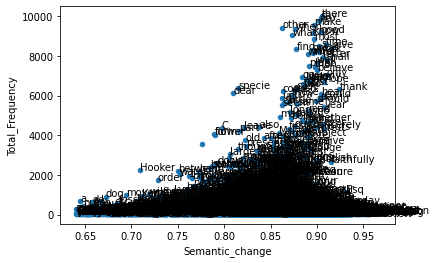

In [ ]:
semantic_change_df_sorted_filtered_p = semantic_change_df_sorted_filtered[['Word','Semantic_change', 'Total_Frequency']]
fig, ax = plt.subplots()
semantic_change_df_sorted_filtered_p.plot('Semantic_change', 'Total_Frequency', kind='scatter', ax=ax)
for k, v in semantic_change_df_sorted_filtered_p.iterrows():
  word = v['Word']
  sc = v['Semantic_change']
  f = v['Total_Frequency']
  #print("w", v['Word'])
  #print("sc:", str(sc))
  #print("f:", str(f))
  ax.annotate(word, xy=(sc,f))

What are the neighbours of these words in the two spaces?

In [ ]:
for word in highfreq_highlychanged_words:
  print(word)
  print("Neighbours in first space:")
  print(model1.wv.similar_by_word(word, 10))
  print("Neighbours in second space:")
  print(model2.wv.similar_by_word(word, 10))

Streaming output truncated to the last 5000 lines.
Lime
Neighbours in first space:
[('Carbonate', 0.9000318646430969), ('Soda', 0.8823838233947754), ('Sulphate', 0.8749704957008362), ('Nitrate', 0.8475675582885742), ('sulphate', 0.8402873873710632), ('alumina', 0.8256251811981201), ('Carb', 0.8220869898796082), ('Moss', 0.8217189311981201), ('soda', 0.8167873024940491), ('gypsum', 0.815299928188324)]
Neighbours in second space:
[('Potassium', 0.9706498980522156), ('Magnesia', 0.9660004377365112), ('Sulphate', 0.9646168351173401), ('buoy', 0.9641621708869934), ('Phosphoric', 0.9607179164886475), ('Acids', 0.958337664604187), ('blackberry', 0.9575578570365906), ('Mirabilis', 0.9570751786231995), ('Sodium', 0.9569314122200012), ('Bears', 0.9547463059425354)]
together
Neighbours in first space:
[('mingle', 0.656972348690033), ('string', 0.6484610438346863), ('suspend', 0.6414031982421875), ('around', 0.6405342221260071), ('beside', 0.6400481462478638), ('load', 0.638911247253418), ('bough'

I print this to an output file:

In [ ]:
outfile = open(os.path.join(output_folder, 'Neighbours_changed_words.csv'), 'w+')

# Write header row:
outfile.write("Word, followed by  neighbours in first space and neighbours in second space\n") 
for word in highfreq_highlychanged_words:
  print(word)
  print("Neighbours in first space:")
  print(model1.wv.similar_by_word(word, 10))
  print("Neighbours in second space:")
  print(model2.wv.similar_by_word(word, 10))
  outfile.write(word+"\n")
  for (w,c) in model1.wv.similar_by_word(word, 10):
    outfile.write(w+"\t"+str(c))
  outfile.write("\n")
  for (w,c) in model2.wv.similar_by_word(word, 10):
    outfile.write(w+"\t"+str(c))
  outfile.write("\n")
  
outfile.close()

Streaming output truncated to the last 5000 lines.
Lime
Neighbours in first space:
[('Carbonate', 0.9000318646430969), ('Soda', 0.8823838233947754), ('Sulphate', 0.8749704957008362), ('Nitrate', 0.8475675582885742), ('sulphate', 0.8402873873710632), ('alumina', 0.8256251811981201), ('Carb', 0.8220869898796082), ('Moss', 0.8217189311981201), ('soda', 0.8167873024940491), ('gypsum', 0.815299928188324)]
Neighbours in second space:
[('Potassium', 0.9706498980522156), ('Magnesia', 0.9660004377365112), ('Sulphate', 0.9646168351173401), ('buoy', 0.9641621708869934), ('Phosphoric', 0.9607179164886475), ('Acids', 0.958337664604187), ('blackberry', 0.9575578570365906), ('Mirabilis', 0.9570751786231995), ('Sodium', 0.9569314122200012), ('Bears', 0.9547463059425354)]
together
Neighbours in first space:
[('mingle', 0.656972348690033), ('string', 0.6484610438346863), ('suspend', 0.6414031982421875), ('around', 0.6405342221260071), ('beside', 0.6400481462478638), ('load', 0.638911247253418), ('bough'

## An approach to semantic change detection using neighbours

We're going to implement the method proposed by Gonen, H., Jawahar, G., Seddah, D., & Goldberg, Y. (2020). Simple, Interpretable and Stable Method for Detecting Words with Usage Change across Corpora. In Proceedings of the 58th Annual Meeting of the Association for Computational Linguistics (pp. 538–555). https://doi.org/10.18653/v1/2020.acl-main.51 

I extract all words with frequency at least 100 in both time periods:

In [ ]:
def extract_top100(model):
  vocab = model.wv.index_to_key
  vocab_100 = []
  for w in vocab:
    if model.wv.get_vecattr(w, "count") >= 100:
      vocab_100.append(w)
  return vocab_100

vocab1_100 = extract_top100(model1)
vocab2_100 = extract_top100(model2)
vocab_100 = list(set(vocab1_100) & set(vocab2_100))

How many words?

In [ ]:
print(str(len(vocab_100)))

1460


I extract the top 100 neighbours and save them in a dictionary mapping a word to the list of its 100 neighbours:

In [ ]:
def extract_neighbours(w2vmodel, vocab_list):
  count = 0
  word2neighbours = dict()
  for w in vocab_list:
    count += 1
    if (count % 100) == 0:
      print(str(count), "out of", str(len(vocab_list)), w)
    neighbours = w2vmodel.wv.similar_by_word(w, 100)
    #print(str(neighbours))
    neighbour_list = list()
    for n in neighbours:
      neighbour_list.append(n[0])
    word2neighbours[w] = neighbour_list
  return word2neighbours

I apply this to model1 and model2 but for all words (not just those with frequency above 100):

In [ ]:
word2neighbours1 = extract_neighbours(model1, model1.wv.index_to_key)
word2neighbours2 = extract_neighbours(model2, model2.wv.index_to_key)

100 out of 23323 man
200 out of 23323 since
300 out of 23323 country
400 out of 23323 white
500 out of 23323 single
600 out of 23323 owe
700 out of 23323 upper
800 out of 23323 Review
900 out of 23323 trace
1000 out of 23323 DIAG
1100 out of 23323 Müller
1200 out of 23323 mass
1300 out of 23323 delight
1400 out of 23323 Botany
1500 out of 23323 bother
1600 out of 23323 O.
1700 out of 23323 considerably
1800 out of 23323 woodcut
1900 out of 23323 display
2000 out of 23323 del
2100 out of 23323 Etty
2200 out of 23323 evident
2300 out of 23323 Sedgwick
2400 out of 23323 Watson
2500 out of 23323 enlarge
2600 out of 23323 prevail
2700 out of 23323 slate
2800 out of 23323 despair
2900 out of 23323 150
3000 out of 23323 gesture
3100 out of 23323 attraction
3200 out of 23323 26th
3300 out of 23323 peach
3400 out of 23323 admission
3500 out of 23323 decrease
3600 out of 23323 superficial
3700 out of 23323 seal
3800 out of 23323 oak
3900 out of 23323 quadruped
4000 out of 23323 boast
4100 out of

For every word in the intersection between the two vcabularies, compare its neighbours in t1 and its neighbours in t2; the semantic change score is the number of shared neighbours between the two divided by 100.
NB This is different from the formula in Gonen et al. (2020), who take the negative of the overlap.

In [ ]:
vocab_12 = list(set(model1.wv.index_to_key) & set(model2.wv.index_to_key))
w2sc = dict()
for w in vocab_12:
  #sc = -len(list(set(word2neighbours1[w]) & set(word2neighbours2[w])))
  sc = len(list(set(word2neighbours1[w]) & set(word2neighbours2[w])))/100
  w2sc[w] = sc

I have saved these scores in the w2sc dictionary. Now I sort it by decreasing score to see which words changed the most:

In [ ]:
w2sc_sorted = sorted(w2sc.items(), key=lambda kv: kv[1], reverse=False)
w2sc_sorted

[('bigoted', 0.0),
 ('phylogeny', 0.0),
 ('Baculite', 0.0),
 ('Secret', 0.0),
 ('idiot', 0.0),
 ('Earthquake', 0.0),
 ('Chemist', 0.0),
 ('ly', 0.0),
 ('Colburn', 0.0),
 ('chap', 0.0),
 ('Bight', 0.0),
 ('Monmouthshire', 0.0),
 ('cancer', 0.0),
 ('compiler', 0.0),
 ('Stars', 0.0),
 ('〈i', 0.0),
 ('Certhia', 0.0),
 ('flamingo', 0.0),
 ('Auld', 0.0),
 ('ruscifolia', 0.0),
 ('Hypothesis', 0.0),
 ('0.48', 0.0),
 ('stridulate', 0.0),
 ('423', 0.0),
 ('Loan', 0.0),
 ('Schoolmaster', 0.0),
 ('elective', 0.0),
 ('bis', 0.0),
 ('Organ', 0.0),
 ('Vicarage', 0.0),
 ('Entomostraca', 0.0),
 ('sneered', 0.0),
 ('Card', 0.0),
 ('Sport', 0.0),
 ('invalided', 0.0),
 ('broil', 0.0),
 ('Hoping', 0.0),
 ('〈off', 0.0),
 ('Latitude', 0.0),
 ('Child', 0.0),
 ('centimetre', 0.0),
 ('surprized', 0.0),
 ('mu〈ch〉', 0.0),
 ('whera', 0.0),
 ('paralysis', 0.0),
 ('cranium', 0.0),
 ('Gassiott', 0.0),
 ('chaffinch', 0.0),
 ('kidney', 0.0),
 ('912', 0.0),
 ('Subject', 0.0),
 ('cloth', 0.0),
 ('exogamy', 0.0),
 ('See',

What are the most changed words?

In [ ]:
top_changed = [i[0] for i in w2sc_sorted][:50]
top_changed

['bigoted',
 'phylogeny',
 'Baculite',
 'Secret',
 'idiot',
 'Earthquake',
 'Chemist',
 'ly',
 'Colburn',
 'chap',
 'Bight',
 'Monmouthshire',
 'cancer',
 'compiler',
 'Stars',
 '〈i',
 'Certhia',
 'flamingo',
 'Auld',
 'ruscifolia',
 'Hypothesis',
 '0.48',
 'stridulate',
 '423',
 'Loan',
 'Schoolmaster',
 'elective',
 'bis',
 'Organ',
 'Vicarage',
 'Entomostraca',
 'sneered',
 'Card',
 'Sport',
 'invalided',
 'broil',
 'Hoping',
 '〈off',
 'Latitude',
 'Child',
 'centimetre',
 'surprized',
 'mu〈ch〉',
 'whera',
 'paralysis',
 'cranium',
 'Gassiott',
 'chaffinch',
 'kidney',
 '912']

What are their neighbours?

In [ ]:
for w in top_changed:
  print(w)
  print(str(word2neighbours1[w]))
  print(str(word2neighbours2[w]))

bigoted
['Physicists', 'nowadays', 'detestably', 'fleeting', 'unwise', 'skilled', 'phraseology', 'malicious', 'visionary', 'asse', 'theologian', 'rigour', 'alphabet', 'phyllotaxy', 'fascinate', 'consciously', 'henceforth', 'truthful', 'notoriously', 'loudly', 'thesis', 'unscrupulous', 'specialist', 'authoress', 'prejudiced', 'educated', 'meritorious', 'utopian', 'Plato', 'overestimate', 'driver', 'mollify', 'immodest', 'cue', 'candidature', 'nobleman', 'Gerard', 'impressive', 'theatrical', 'woo', 'unbeliever', 'thot', 'qualify', 'decency', 'drs', 'sectional', 'agreeing', 'couplet', 'handed', 'orally', 'champion', 'truism', 'intuition', 'bluntly', 'incite', 'writ', 'exogamy', 'calibre', 'beneficent', 'rudeness', 'pronunciation', 'possesse', 'unmarried', 'dolt', 'allowable', 'overthrow', 'Transaction', 'lagrange', 'Lawyer', 'delude', 'spleen', 'enthusiast', 'happyness', 'imbecile', 'Scheme', 'hallucination', 'unpopularity', 'pious', 'gratiolet', 'statesman', 'Leibnitz', 'Edinbourgh', 'Ex

In [ ]:
semantic_change_neighbours_df = pd.DataFrame(([w, w2sc[w], model1.wv.get_vecattr(w, "count") , model2.wv.get_vecattr(w, "count") ] for w in vocab_12), columns = ('Word', 'Semantic_change_neighbour_score', "Frequency_t1", "Frequency_t2"))
semantic_change_neighbours_df.describe()

,Semantic_change_neighbour_score,Frequency_t1,Frequency_t2
count,23323.000000,23323.000000,23323.000000
mean,0.047947,113.853664,71.983321
std,0.078734,2445.143893,1548.956199
min,0.000000,2.000000,1.000000
25%,0.000000,3.000000,2.000000
50%,0.020000,7.000000,4.000000
75%,0.050000,20.000000,13.000000
max,0.670000,284506.000000,174605.000000


Visualise the distribution of the semantic change scores with a histogram:

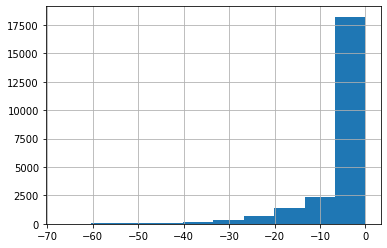

In [ ]:
hist = semantic_change_neighbours_df['Semantic_change_neighbour_score'].hist()

Now I sort by decreasing semantic change score:

In [ ]:
semantic_change_neighbours_df_sorted = semantic_change_neighbours_df.sort_values(by='Semantic_change_neighbour_score', ascending=False)
semantic_change_neighbours_df_sorted.head()

,Word,Semantic_change_neighbour_score,Frequency_t1,Frequency_t2
10395,8,0.67,387,251
7572,June,0.65,243,153
15493,April,0.64,214,136
3958,15,0.63,263,162
22612,5,0.63,785,490


I add the total frequency:

In [ ]:
semantic_change_neighbours_df_sorted["Total_Frequency"] = semantic_change_neighbours_df_sorted["Frequency_t1"]+semantic_change_neighbours_df_sorted["Frequency_t2"]
semantic_change_neighbours_df_sorted

,Word,Semantic_change_neighbour_score,Frequency_t1,Frequency_t2,Total_Frequency
10395,8,0.67,387,251,638
7572,June,0.65,243,153,396
15493,April,0.64,214,136,350
3958,15,0.63,263,162,425
22612,5,0.63,785,490,1275
...,...,...,...,...,...
18020,animalcule,0.00,4,3,7
12366,Assembly,0.00,3,2,5
12368,chef,0.00,3,2,5
12369,dexterously,0.00,3,2,5


I add a column with the category (function word, foreign word, numeral, and proper noun).

In [ ]:
# create a list of our conditions
conditions = [
    (semantic_change_neighbours_df_sorted['Word'].isin(function_words)), # function words
    ((semantic_change_neighbours_df_sorted.Word.str.isdigit()) | (semantic_change_neighbours_df_sorted['Word'].str.match('^\d*?1st$')) | (semantic_change_neighbours_df_sorted['Word'].str.match('^\d*?2nd$')) | (semantic_change_neighbours_df_sorted['Word'].str.match('^\d*?3rd$')) | (semantic_change_neighbours_df_sorted['Word'].str.match('^\d*[^123]th$'))), # numbers
    (semantic_change_neighbours_df_sorted['Word'].apply(lambda x: x[0].isupper() and x[1:len(x)].islower())), # proper nouns
    (np.invert(semantic_change_neighbours_df_sorted['Word'].str.lower().isin(english_vocab))) # foreign words
    ]

# create a list of the values we want to assign for each condition
values = ['Function word','Numeral', 'Proper noun', 'Foreign word']

# create a new column and use np.select to assign values to it using our lists as arguments
semantic_change_neighbours_df_sorted['Category_automatic'] = np.select(conditions, values, default = "")
semantic_change_neighbours_df_sorted

,Word,Semantic_change_neighbour_score,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
10395,8,0.67,387,251,638,Numeral
7572,June,0.65,243,153,396,Proper noun
15493,April,0.64,214,136,350,Proper noun
3958,15,0.63,263,162,425,Numeral
22612,5,0.63,785,490,1275,Numeral
...,...,...,...,...,...,...
18020,animalcule,0.00,4,3,7,
12366,Assembly,0.00,3,2,5,Proper noun
12368,chef,0.00,3,2,5,
12369,dexterously,0.00,3,2,5,


I save this to a file:

In [ ]:
output_folder = '/content/drive/MyDrive/2021/Darwin paper/Files/Semantic_change_output/'
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
semantic_change_neighbours_df_sorted.to_csv(os.path.join(output_folder, 'semantic_change_all_words_neighbourscore.csv'), encoding='utf-8')

## Comparison of the two methods for semantic change detection

In [ ]:
semantic_change_neighbours_df_sorted.sort_values(by='Word', ascending=True)

,Word,Semantic_change_neighbour_score,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
6800,,0.18,839,519,1358,Foreign word
11086,,0.41,28553,20542,49095,Foreign word
12025,,0.04,13,8,21,Foreign word
5271,,0.00,10,6,16,Foreign word
4704,,0.00,7,5,12,Foreign word
...,...,...,...,...,...,...
7540,☿,0.01,3,2,5,Foreign word
3450,♀,0.05,286,174,460,Foreign word
7891,♂,0.08,232,146,378,Foreign word
16428,〈,0.00,21,14,35,Foreign word


In [ ]:
semantic_change_df_sorted.sort_values(by='Word', ascending=True)

,Word,Semantic_change,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic
337,,0.608477,839,519,1358,Foreign word
9,,0.907153,28553,20542,49095,Foreign word
7764,,0.816607,13,8,21,Foreign word
9074,,0.743481,10,6,16,Foreign word
10790,,0.752919,7,5,12,Foreign word
...,...,...,...,...,...,...
17356,☿,0.930396,3,2,5,Foreign word
920,♀,0.657239,286,174,460,Foreign word
1085,♂,0.699293,232,146,378,Foreign word
5556,〈,0.627050,21,14,35,Foreign word


In [ ]:
semantic_change_2methods = semantic_change_df_sorted.merge(semantic_change_neighbours_df_sorted, how = 'inner')
semantic_change_2methods

,Word,Semantic_change,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Semantic_change_neighbour_score
0,Boyd,0.986384,12,7,19,Proper noun,0.31
1,avec,0.985623,3,2,5,Foreign word,0.17
2,vom,0.983580,4,2,6,Foreign word,0.12
3,mit,0.982179,7,4,11,Foreign word,0.34
4,Familie,0.982051,2,2,4,Proper noun,0.10
...,...,...,...,...,...,...,...
23318,Sara,0.474424,41,26,67,Proper noun,0.00
23319,Caspary,0.471753,22,14,36,Proper noun,0.00
23320,Utricularia,0.468762,68,43,111,Proper noun,0.00
23321,1879,0.467864,36,23,59,Numeral,0.00


I integrate the neighbour-based semantic change score in the file:

In [ ]:
semantic_change_2methods_all = semantic_change_df_sorted.merge(semantic_change_neighbours_df_sorted, how = 'outer')
semantic_change_2methods_all.to_csv(os.path.join(output_folder, 'semantic_change_all_words_2scores.csv'), encoding='utf-8')
semantic_change_2methods_all

,Word,Semantic_change,Frequency_t1,Frequency_t2,Total_Frequency,Category_automatic,Semantic_change_neighbour_score
0,Boyd,0.986384,12,7,19,Proper noun,0.31
1,avec,0.985623,3,2,5,Foreign word,0.17
2,vom,0.983580,4,2,6,Foreign word,0.12
3,mit,0.982179,7,4,11,Foreign word,0.34
4,Familie,0.982051,2,2,4,Proper noun,0.10
...,...,...,...,...,...,...,...
23318,Sara,0.474424,41,26,67,Proper noun,0.00
23319,Caspary,0.471753,22,14,36,Proper noun,0.00
23320,Utricularia,0.468762,68,43,111,Proper noun,0.00
23321,1879,0.467864,36,23,59,Numeral,0.00


I plot the terms by two semantic change scores:

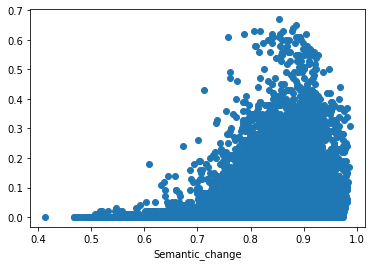

In [ ]:
ax = semantic_change_2methods.set_index('Semantic_change')['Semantic_change_neighbour_score'].plot(style='o')

There seems to be a positive correlation: the higher the cosine semantic change the higher the neighbour semantic change.